# LAT Thermal Control Plots

### Robert Cameron, September 2015

In [1]:
from astropy.table import Table, Column
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import datetime as dt
%matplotlib inline
plt.rc('figure', figsize = [16, 16])
plt.rc('font', size = 18)

In [2]:
# read regular ASCII tabular file of beta angle history
betafile = "/Users/rac/Documents/GLAST/ISOC/LATmetrics/beta/betang.txt"
betatab = Table.read(betafile, format='ascii')
bymd = betatab['YMD']
bhms = betatab['HMS']
bxformat = "%Y-%m-%d%H:%M:%S"
bx = [dt.datetime.strptime(bymd[i]+bhms[i],bxformat) for i in range(len(bymd))]

In [3]:
# read irregular ASCII tabular file of history of VCHP control
htrfile = "/Users/rac/Documents/GLAST/ISOC/LATmetrics/LTC/htr.history"
df = pd.read_csv(htrfile, parse_dates=[1], delimiter="\t",header=None)
(hymd,tot0,off0,tot6,off6,tot7,off7) = (df[0],df[2],df[3],df[5],df[6],df[8],df[9])

ok = (tot0 > 0) & (tot6 > 0) & (tot7 > 0)

hymd = hymd[ok]
tot0 = tot0[ok]
off0 = off0[ok]
tot6 = tot6[ok]
off6 = off6[ok]
tot7 = tot7[ok]
off7 = off7[ok]
f0 = off0/tot0
f6 = off6/tot6
f7 = off7/tot7
#VCHP0 = 1-pd.rolling_window(f0,20,win_type='boxcar',center=True)
#VCHP6 = 1-pd.rolling_window(f6,20,win_type='boxcar',center=True)
#VCHP7 = 1-pd.rolling_window(f7,20,win_type='boxcar',center=True)

VCHP0 = 1-pd.Series.rolling(f0,axis=0,window=20,win_type='boxcar',center=True).mean()
VCHP6 = 1-pd.Series.rolling(f6,axis=0,window=20,win_type='boxcar',center=True).mean()
VCHP7 = 1-pd.Series.rolling(f7,axis=0,window=20,win_type='boxcar',center=True).mean()

fx = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in hymd]

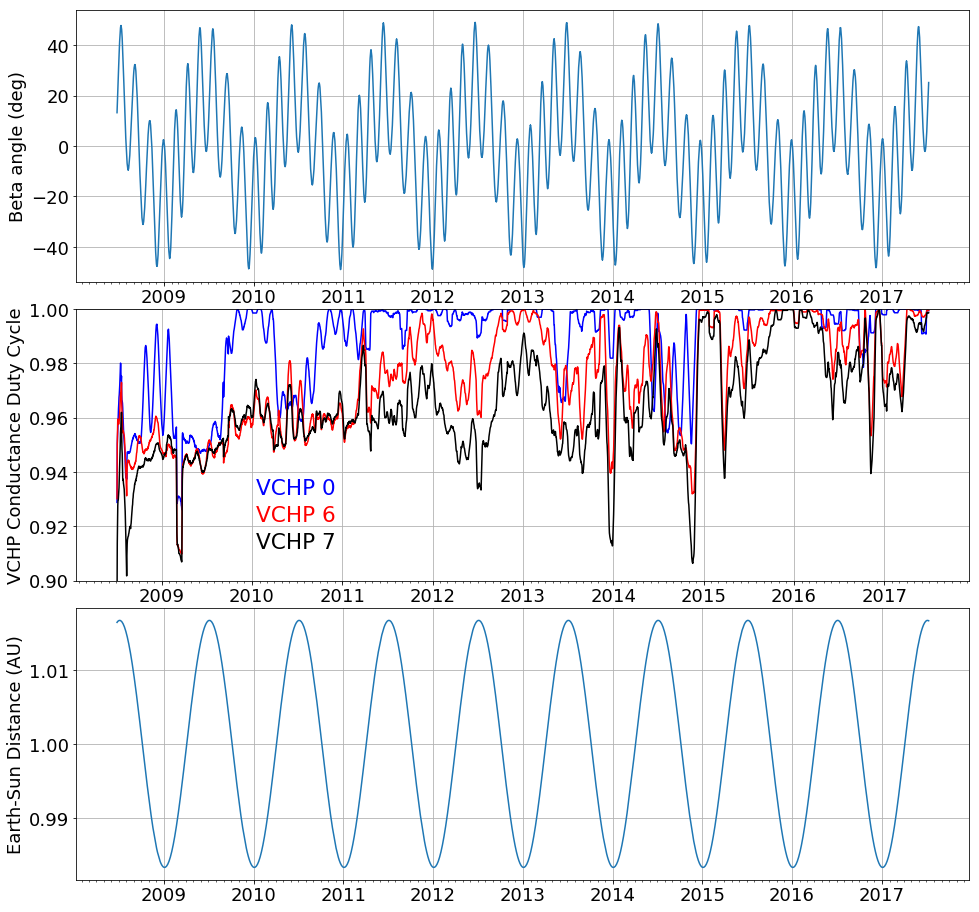

In [4]:
# 3 subplots for beta, VCHP, rAU, where the axes array is 1-d

#fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)
fig, (ax1, ax2, ax3) = plt.subplots(3)

years    = mdates.YearLocator()   # every year
months   = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

ax1.plot(bx, betatab['beta'])
ax1.xaxis.set_major_locator(years)
ax1.xaxis.set_major_formatter(yearsFmt)
ax1.xaxis.set_minor_locator(months)

#datemin = dt.date(int(yb[0]), 1, 1)
#datemax = dt.date(int(yb[-1])+1, 1, 1)
#datemin = dt.date(2008, 1, 3)
#datemax = dt.date(2017, 12, 31)
#ax1.set_xlim(datemin, datemax)

ax1.grid(True)
ax1.set_ylabel('Beta angle (deg)')

ax2.plot(fx,VCHP0,'-b',label='VCHP0')
ax2.plot(fx,VCHP6,'-r',label='VCHP6')
ax2.plot(fx,VCHP7,'-k',label='VCHP7')
ax2.grid(True)
#ax2.set_xlim(datemin, datemax)
ax2.xaxis.set_minor_locator(months)
ax2.set_ylim(0.9,1.0)
#ax2.legend(loc='lower center',fontsize='small')
ax2.set_ylabel('VCHP Conductance Duty Cycle')
captionx = dt.date(2010,1,15)
ax2.text(captionx,0.932,"VCHP 0",color='b',fontsize='large')
ax2.text(captionx,0.922,"VCHP 6",color='r',fontsize='large')
ax2.text(captionx,0.912,"VCHP 7",color='k',fontsize='large')

ax3.plot(bx, betatab['rAU'])
ax3.grid(True)
ax3.xaxis.set_minor_locator(months)
#ax3.set_xlim(datemin, datemax)
ax3.set_ylabel('Earth-Sun Distance (AU)')

fig.subplots_adjust(hspace=0.1)
#fig.autofmt_xdate()